In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import matplotlib as mpl
import numpy as np
from material_models import GOH_fullyinc
from misc import preprocessing, normalization, predict
import tensorflow as tf
import pickle
fsize=5
pltparams = {'legend.fontsize': 'large',
          'figure.figsize': (fsize*5,fsize),
          'font.size'     : 4*fsize,
          'axes.labelsize': 4*fsize,
          'axes.titlesize': 4*fsize,
          'xtick.labelsize': 3.5*fsize,
          'ytick.labelsize': 3.5*fsize,
          'lines.linewidth': 5,
          'lines.markersize': 10,
          'lines.markeredgewidth': 2,
          'axes.titlepad': 25,
          "mathtext.fontset": 'dejavuserif',
          'axes.labelpad': 5}
plt.rcParams.update(pltparams)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0.1, 0.7, 2)))
import pandas as pd

In [2]:
idx = 0
samples = ['S111S1', 'S111S4', 'S112S2', 'S112S3', 'S112S4', 'S113S3', 'S113S4', 'S143S1', 'S143S2', 'S144S3', 'S144S4']
limits = [[0, 183, 2*183, 3*183], [0, 184, 367, 3*183], [0, 184, 367, 3*183], [0, 183, 366, 3*183], [0, 184, 367, 3*183], [0, 183, 366, 3*183], 
            [0, 183, 366, 3*183], [0, 62, 121, 3*183], [0, 62, 123, 3*183], [0, 62, 123, 3*183], [0, 62, 123, 3*183]]
sample = samples[idx]
lim = limits[idx]
data = sample+'_xyb'
ndata, _, _, _, _, Psi_gt, X, Y, sigma, F, C, _  = preprocessing(data, theta=0)
Finv = np.linalg.inv(F)
S = np.einsum('...ij,...jk,...lk->...il', Finv, sigma, Finv)
axislabels=['Off-x', 'Off-y', 'Equibiaxial']

In [19]:
# Check pointwise monotonicity of S wrt C
global_convexity = np.zeros(ndata)
for i in range(ndata):
    for j in range(ndata):
        temp = np.einsum('ij,ij', S[i]-S[j], C[i]-C[j])
        global_convexity[i]+= np.min([0,temp])

# conv_score = np.array([np.einsum('ij,ij', (S[i+1]-S[i]), C[i+1]-C[i]) for i in range(S.shape[0]-1)])
# conv_score = np.clip(conv_score, a_min=min(conv_score), a_max=0)
# av_score = conv_score.mean()
global_convexity = global_convexity/np.max(np.abs(global_convexity))

In [20]:
global_convexity = np.log(1-global_convexity)
global_convexity = global_convexity/np.max(np.abs(global_convexity))

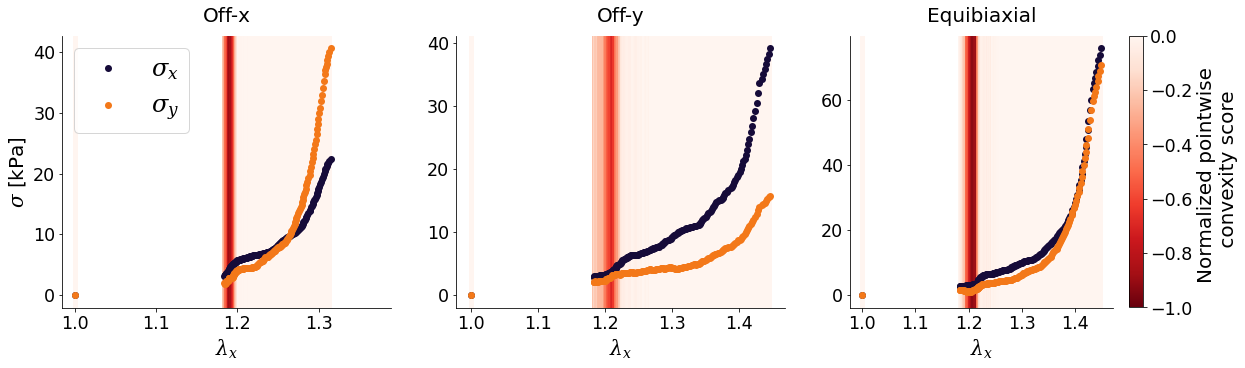

: 

In [24]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
for i in range(3):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set(xlabel = '$\\lambda_x$')

        i1 = lim[i]
        i2 = lim[i+1]
        for j in range(i1,i2-1):
            ax[i].axvline(X[j,0], color=plt.cm.Reds([global_convexity[j]]))
            # ax[i].axvline(X[j,0], color='r', alpha= -0.75*conv_score[j])

        ax[i].plot(X[i1:i2,0], sigma[i1:i2,0,0]*1000,'.', label='$\\sigma_x$')
        ax[i].plot(X[i1:i2,0], sigma[i1:i2,1,1]*1000,'.', label='$\\sigma_y$')
        ax[i].text(0.5,1.05,axislabels[i], transform=ax[i].transAxes, ha='center')

xmax = max(X[lim[1]-1,0], X[lim[1]-1,1])
ax[0].set(ylabel = '$\\sigma$ [kPa]', xlim=[0.985, xmax])
ax[0].legend()
cmap = plt.cm.Reds([0,0.5])
norm = mpl.colors.Normalize(vmin=-1, vmax=0)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds_r'), ax=ax[2], label='Normalized pointwise \n convexity score')
fig.savefig('figs/fig_data_convexity.jpg', dpi=300, bbox_inches='tight')